# Do probe training (HF dataset activations)

Load the activations and labels from HF, aggregate, and construct datasets to train the probe on (note sklearn doesn't require a validation dataset).

In [ ]:
import probe_gen.probes as probes
from sklearn.metrics import classification_report


activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("refusal_5k_on", 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True, verbose=True)

Create a probe and fit it.

In [2]:
# Initialise and fit a probe with the datasets
probe = probes.SklearnLogisticProbe(use_bias=True)
probe.fit(train_dataset, val_dataset, normalize=False)

Training probe...


Evaluate the probe on test dataset.

In [3]:
# Evaluate the model
eval_dict, y_pred, y_pred_proba = probe.eval(test_dataset)
print(eval_dict)
print(classification_report(test_dataset['y'], y_pred))

{'accuracy': 0.936, 'roc_auc': 0.9795039999999999, 'tpr_at_1_fpr': np.float64(0.838)}
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       500
         1.0       0.95      0.92      0.93       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



Nice visualisation to see how the probe splits the two classes

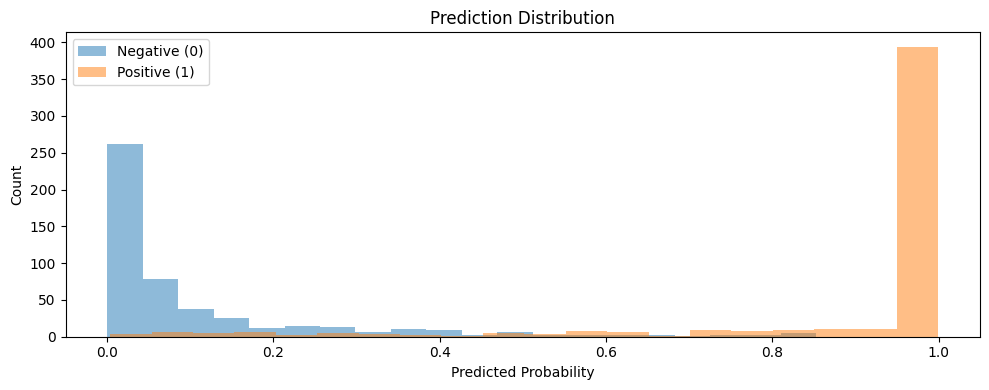

In [4]:
from probe_gen.standard_experiments.experiment_plotting import plot_per_class_prediction_distributions

plot_per_class_prediction_distributions(test_dataset['y'], y_pred_proba)

# Testing On-Off Probes

In [ ]:
from probe_gen.standard_experiments.grid_experiments import run_grid_experiment

run_grid_experiment(
    ['refusal_5k_on', 'refusal_5k_off_other_model'], 
    10, 
    True, # use_bias
    False # normalize
)

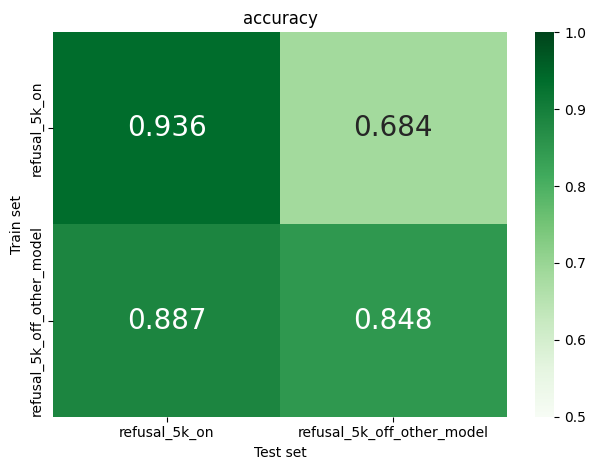

In [2]:
from probe_gen.standard_experiments.experiment_plotting import plot_results_table

plot_results_table(['refusal_5k_on', 'refusal_5k_off_other_model'], 12, 'mean', True, False, 'accuracy')

# Layer experiments

In [ ]:
from probe_gen.standard_experiments.layer_experiments import run_layer_experiments

use_bias = True
normalize_inputs = True

run_layer_experiments(
    "mean",
    "refusal_5k_off_other_model",
    [i for i in range(10,18)], 
    use_bias_options=[True, False], 
    normalize_inputs_options=[True, False], 
)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samdower to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


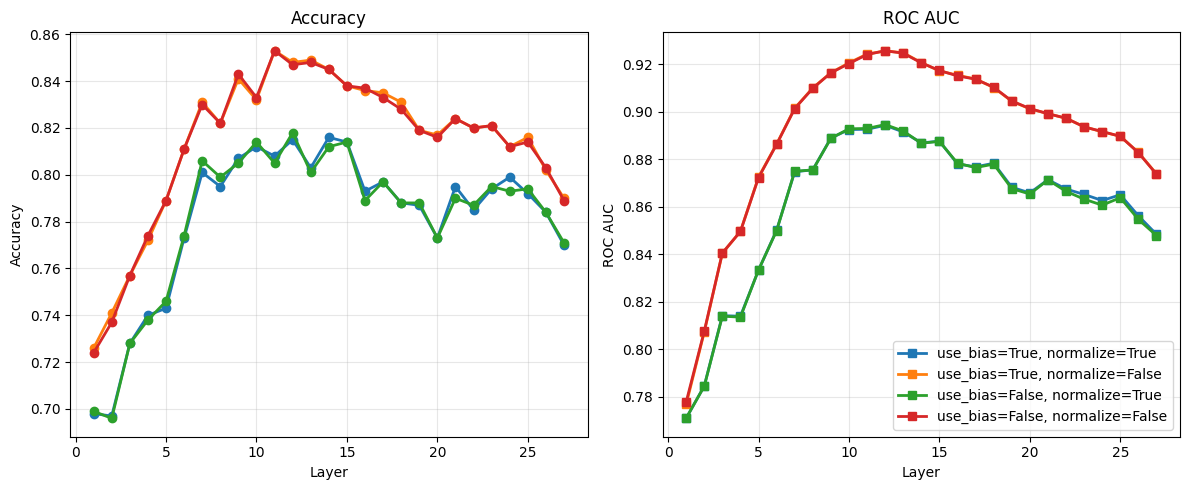

In [1]:
from probe_gen.standard_experiments.experiment_plotting import plot_layer_experiment

plot_layer_experiment([i for i in range(1,28)], 'refusal_5k_off_other_model')

# Hyperparameter Search

In [10]:
import probe_gen.probes as probes
from sklearn.metrics import classification_report


activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("refusal_5k_on", 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True, verbose=True)

loaded labels
loaded activations with shape torch.Size([5000, 277, 3072])
calculated attention mask with shape torch.Size([5000, 277])
Train: 4000 samples, 2000.0 positives
Val:   0 samples, 0.0 positives
Test:  1000 samples, 500.0 positives


In [ ]:
# Evaluate the model
eval_dict, y_pred, y_pred_proba = probe.eval(test_dataset)
print(eval_dict)
print(classification_report(test_dataset['y'], y_pred))

In [11]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
evals_norm_true_bias_true = []
evals_norm_true_bias_false = []
evals_norm_false_bias_true = []
evals_norm_false_bias_false = []

for C in C_values:
    print(f"############ {C} #############")

    probe = probes.SklearnLogisticProbe(use_bias=True, C=C)
    probe.fit(train_dataset, val_dataset, normalize=True)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_true_bias_true.append(eval_dict)

    probe = probes.SklearnLogisticProbe(use_bias=False, C=C)
    probe.fit(train_dataset, val_dataset, normalize=True)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_true_bias_false.append(eval_dict)

    probe = probes.SklearnLogisticProbe(use_bias=True, C=C)
    probe.fit(train_dataset, val_dataset, normalize=False)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_false_bias_true.append(eval_dict)

    probe = probes.SklearnLogisticProbe(use_bias=False, C=C)
    probe.fit(train_dataset, val_dataset, normalize=False)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_false_bias_false.append(eval_dict)

############ 0.0001 #############
Training probe...
Training probe...
Training probe...
Training probe...
############ 0.001 #############
Training probe...
Training probe...
Training probe...
Training probe...
############ 0.01 #############
Training probe...
Training probe...
Training probe...
Training probe...
############ 0.1 #############
Training probe...
Training probe...
Training probe...
Training probe...
############ 1 #############
Training probe...
Training probe...
Training probe...
Training probe...
############ 10 #############
Training probe...
Training probe...
Training probe...
Training probe...
############ 100 #############
Training probe...
Training probe...
Training probe...
Training probe...
############ 1000 #############
Training probe...
Training probe...
Training probe...
Training probe...
############ 10000 #############
Training probe...
Training probe...
Training probe...
Training probe...


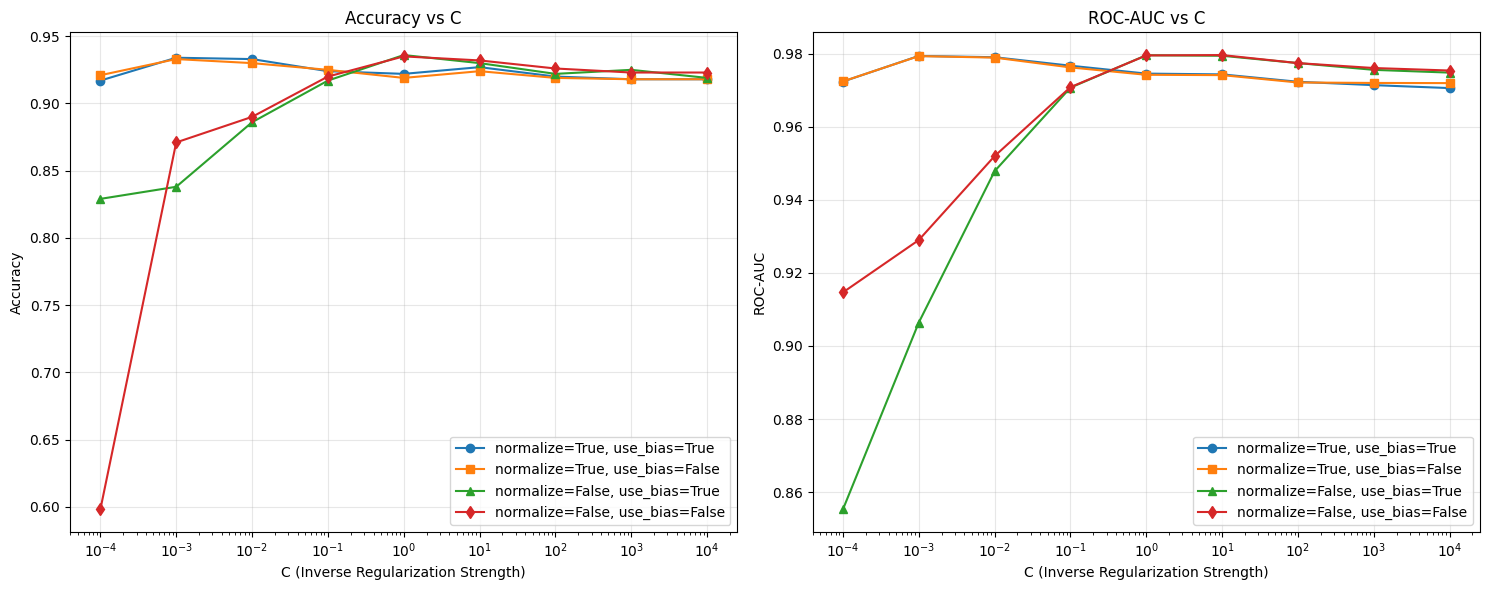

Best Accuracy Results:
normalize=True, use_bias=True: C=0.001, Accuracy=0.9340
normalize=True, use_bias=False: C=0.001, Accuracy=0.9330
normalize=False, use_bias=True: C=1, Accuracy=0.9360
normalize=False, use_bias=False: C=1, Accuracy=0.9350

Best ROC-AUC Results:
normalize=True, use_bias=True: C=0.001, ROC-AUC=0.9794
normalize=True, use_bias=False: C=0.001, ROC-AUC=0.9793
normalize=False, use_bias=True: C=1, ROC-AUC=0.9796
normalize=False, use_bias=False: C=10, ROC-AUC=0.9796


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extract accuracy and ROC-AUC values for each configuration
def extract_metrics(results_list):
    accuracy = [result['accuracy'] for result in results_list]
    roc_auc = [result['roc_auc'] for result in results_list]
    return accuracy, roc_auc

# Extract metrics for all configurations
acc1, roc1 = extract_metrics(evals_norm_true_bias_true)
acc2, roc2 = extract_metrics(evals_norm_true_bias_false)
acc3, roc3 = extract_metrics(evals_norm_false_bias_true)
acc4, roc4 = extract_metrics(evals_norm_false_bias_false)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define labels for each configuration (modify these based on your actual hyperparameter combinations)
config_labels = [
    'normalize=True, use_bias=True',  # Replace with actual hyperparameter values, e.g., 'penalty=l2, solver=lbfgs'
    'normalize=True, use_bias=False',  # e.g., 'penalty=l2, solver=liblinear'
    'normalize=False, use_bias=True',  # e.g., 'penalty=l1, solver=liblinear'
    'normalize=False, use_bias=False'   # e.g., 'penalty=elasticnet, solver=saga'
]

# Plot accuracy (left subplot)
ax1.semilogx(C_values, acc1, marker='o', label=config_labels[0])
ax1.semilogx(C_values, acc2, marker='s', label=config_labels[1])
ax1.semilogx(C_values, acc3, marker='^', label=config_labels[2])
ax1.semilogx(C_values, acc4, marker='d', label=config_labels[3])

ax1.set_xlabel('C (Inverse Regularization Strength)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs C')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot ROC-AUC (right subplot)
ax2.semilogx(C_values, roc1, marker='o', label=config_labels[0])
ax2.semilogx(C_values, roc2, marker='s', label=config_labels[1])
ax2.semilogx(C_values, roc3, marker='^', label=config_labels[2])
ax2.semilogx(C_values, roc4, marker='d', label=config_labels[3])

ax2.set_xlabel('C (Inverse Regularization Strength)')
ax2.set_ylabel('ROC-AUC')
ax2.set_title('ROC-AUC vs C')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Optional: Find and print the best configuration for each metric
def find_best_config(metric_lists, config_labels, C_values):
    best_scores = []
    for i, metrics in enumerate(metric_lists):
        best_idx = np.argmax(metrics)
        best_scores.append({
            'config': config_labels[i],
            'best_C': C_values[best_idx],
            'best_score': metrics[best_idx]
        })
    return best_scores

# Find best configurations
accuracy_lists = [acc1, acc2, acc3, acc4]
roc_lists = [roc1, roc2, roc3, roc4]

print("Best Accuracy Results:")
best_acc = find_best_config(accuracy_lists, config_labels, C_values)
for result in best_acc:
    print(f"{result['config']}: C={result['best_C']}, Accuracy={result['best_score']:.4f}")

print("\nBest ROC-AUC Results:")
best_roc = find_best_config(roc_lists, config_labels, C_values)
for result in best_roc:
    print(f"{result['config']}: C={result['best_C']}, ROC-AUC={result['best_score']:.4f}")

# Training Consistency

In [ ]:
import probe_gen.probes as probes
from sklearn.metrics import classification_report


activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("refusal_5k_off_other_model", 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True, verbose=True)

In [ ]:
import torch

accuracies = []
roc_aucs = []
for i in range(15):

    probe = probes.SklearnLogisticProbe(use_bias=True, C=0.001, seed=i)
    probe.fit(train_dataset, val_dataset, normalize=True)
    eval_dict, _, _ = probe.eval(test_dataset)

    accuracies.append(eval_dict['accuracy'])
    roc_aucs.append(eval_dict['roc_auc'])

accuracies = torch.tensor(accuracies)
roc_aucs = torch.tensor(roc_aucs)

Training probe...
Training probe...
Training probe...
Training probe...
Training probe...
Training probe...
Training probe...
Training probe...
Training probe...
Training probe...


In [19]:
print(accuracies.var())
print(roc_aucs.var())
print("\n", accuracies.mean())
print(roc_aucs.mean())

tensor(0.)
tensor(3.9475e-15)

 tensor(0.9340)
tensor(0.9794)
